[Index](Index.ipynb) - [Back](Widget Styling.ipynb)

In [1]:
from __future__ import print_function # For py 2.7 compat

# Building a Custom Widget - Hello World

The widget framework is built on top of the Comm framework (short for communication).  The Comm framework is a framework that allows you send/receive JSON messages to/from the front end (as seen below).

![Widget layer](images/WidgetArch.png)

To create a custom widget, you need to define the widget both in the browser and in the python kernel.

## Building a Custom Widget

To get started, you'll create a simple hello world widget.  Later you'll build on this foundation to make more complex widgets.

## Python Kernel

### DOMWidget and Widget

To define a widget, you must inherit from the Widget or DOMWidget base class.  If you intend for your widget to be displayed in the Jupyter notebook, you'll want to inherit from the DOMWidget.  The DOMWidget class itself inherits from the Widget class.  The Widget class is useful for cases in which the Widget is not meant to be displayed directly in the notebook, but instead as a child of another rendering environment.  For example, if you wanted to create a three.js widget (a popular WebGL library), you would implement the rendering window as a DOMWidget and any 3D objects or lights meant to be rendered in that window as Widgets.

### _view_name

Inheriting from the DOMWidget does not tell the widget framework what front end widget to associate with your back end widget.  Instead, you must tell it yourself by defining a specially named traitlet, `_view_name` (as seen below).

In [2]:
import ipywidgets as widgets
from traitlets import Unicode


class HelloWidget(widgets.DOMWidget):
    _view_name = Unicode('HelloView').tag(sync=True)
    _view_module = Unicode('hello').tag(sync=True)

### sync=True traitlets

Traitlets is an IPython library for defining type-safe properties on configurable objects.  For this tutorial you do not need to worry about the *configurable* piece of the traitlets machinery.   The `sync=True` keyword argument tells the widget framework to handle synchronizing that value to the browser.  Without `sync=True`, the browser would have no knowledge of `_view_name`.

### Other traitlet types

Unicode, used for _view_name, is not the only Traitlet type, there are many more some of which are listed below:  

- Any
- Bool
- Bytes
- CBool
- CBytes
- CComplex
- CFloat
- CInt
- CLong
- CRegExp
- CUnicode
- CaselessStrEnum
- Complex
- Dict
- DottedObjectName
- Enum
- Float
- FunctionType
- Instance
- InstanceType
- Int
- List
- Long
- Set
- TCPAddress
- Tuple
- Type
- Unicode
- Union


Not all of these traitlets can be synchronized across the network, only the JSON-able traits and Widget instances will be synchronized.

## Front end (JavaScript)

### Models and views

The IPython widget framework front end relies heavily on [Backbone.js](http://backbonejs.org/).  Backbone.js is an MVC (model view controller) framework.  Widgets defined in the back end are automatically synchronized with generic Backbone.js models in the front end.  The traitlets are added to the front end instance automatically on first state push.  The `_view_name` trait that you defined earlier is used by the widget framework to create the corresponding Backbone.js view and link that view to the model.

### Import the WidgetManager

You first need to import the `jupyter-js-widgets` module. To import modules, use the `define` method of [require.js](http://requirejs.org/) (as seen below).

In [3]:
%%javascript
define('hello', ["jupyter-js-widgets"], function(widgets) {
    
});

<IPython.core.display.Javascript object>

### Define the view

Next define your widget view class.  Inherit from the `DOMWidgetView` by using the `.extend` method.

In [4]:
%%javascript
require.undef('hello');

define('hello', ["jupyter-js-widgets"], function(widgets) {
    
    // Define the HelloView
    var HelloView = widgets.DOMWidgetView.extend({
        
    });

    return {
        HelloView: HelloView
    }
});

<IPython.core.display.Javascript object>

### Render method

Lastly, override the base `render` method of the view to define custom rendering logic.  A handle to the widget's default div element can be acquired via `this.$el`.  The `$el` property is a [jQuery](http://jquery.com/) object handle (which can be thought of as a supercharged version of the normal DOM element's handle).

In [5]:
%%javascript
require.undef('hello');

define('hello', ["jupyter-js-widgets"], function(widgets) {
    
    var HelloView = widgets.DOMWidgetView.extend({
        
        // Render the view.
        render: function() { 
            this.$el.text('Hello World!'); 
        },
    });
    
    return {
        HelloView: HelloView
    };
});

<IPython.core.display.Javascript object>

## Test

You should be able to display your widget just like any other widget now.

In [6]:
HelloWidget()

## Making the widget stateful

There is not much that you can do with the above example that you can't do with the IPython display framework.  To change this, you will make the widget stateful.  Instead of displaying a static "hello world" message, it will display a string set by the back end.  First you need to add a traitlet in the back end.  Use the name of `value` to stay consistent with the rest of the widget framework and to allow your widget to be used with interact.

In [7]:
class HelloWidget(widgets.DOMWidget):
    _view_name = Unicode('HelloView').tag(sync=True)
    _view_module = Unicode('hello').tag(sync=True)
    value = Unicode('Hello World!').tag(sync=True)

### Accessing the model from the view

To access the model associate with a view instance, use the `model` property of the view.  `get` and `set` methods are used to interact with the Backbone model.  `get` is trivial, however you have to be careful when using `set`.  After calling the model `set` you need call the view's `touch` method.  This associates the `set` operation with a particular view so output will be routed to the correct cell.  The model also has an `on` method which allows you to listen to events triggered by the model (like value changes).

### Rendering model contents

By replacing the string literal with a call to `model.get`, the view will now display the value of the back end upon display.  However, it will not update itself to a new value when the value changes.

In [8]:
%%javascript
require.undef('hello');

define('hello', ["jupyter-js-widgets"], function(widgets) {
    
    var HelloView = widgets.DOMWidgetView.extend({
        
        render: function() { 
            this.$el.text(this.model.get('value')); 
        },
    });
    
    return {
        HelloView : HelloView
    };
});

<IPython.core.display.Javascript object>

### Dynamic updates

To get the view to update itself dynamically, register a function to update the view's value when the model's `value` property changes.  This can be done using the `model.on` method.  The `on` method takes three parameters, an event name, callback handle, and callback context.   The Backbone event named `change` will fire whenever the model changes.  By appending `:value` to it, you tell Backbone to only listen to the change event of the `value` property (as seen below).

In [9]:
%%javascript
require.undef('hello');

define('hello', ["jupyter-js-widgets"], function(widgets) {
    
    var HelloView = widgets.DOMWidgetView.extend({
        
        render: function() { 
            this.value_changed();
            this.model.on('change:value', this.value_changed, this);
        },
        
        value_changed: function() {
            this.$el.text(this.model.get('value')); 
        },
    });
    
    return {
        HelloView : HelloView
    };
});

<IPython.core.display.Javascript object>

## Test

In [10]:
w = HelloWidget()
w

In [11]:
w.value = 'test'

## Finishing

### Bidirectional communication

The examples above dump the value directly into the DOM.  There is no way for you to interact with this dumped data in the front end.  To create an example that accepts input, you will have to do something more than blindly dumping the contents of value into the DOM.  In this part of the tutorial, you will use a jQuery spinner to display and accept input in the front end.

#### Update the Python code

You will need to change the type of the value traitlet to `Int`.  It also makes sense to change the name of the widget to something more appropriate, like `SpinnerWidget`.

In [12]:
from traitlets import CInt


class SpinnerWidget(widgets.DOMWidget):
    _view_name = Unicode('SpinnerView').tag(sync=True)
    _view_module = Unicode('spinner').tag(sync=True)
    value = CInt().tag(sync=True)

#### Updating the Javascript code

The [jQuery docs for the spinner control](https://jqueryui.com/spinner/) say to use `.spinner` to create a spinner in an element.  Calling `.spinner` on `$el` will create a spinner inside `$el`.  Make sure to update the widget name here too so it's the same as `_view_name` in the back end.

In [13]:
%%javascript
define('spinner', ["jupyter-js-widgets"], function(widgets) {
    
    var SpinnerView = widgets.DOMWidgetView.extend({
        
        render: function() { 
            
            // jQuery code to create a spinner and append it to $el
            this.$input = $('<input />');
            this.$el.append(this.$input);
            this.$spinner = this.$input.spinner({
                change: function( event, ui ) {}
            });
            
            this.value_changed();
            this.model.on('change:value', this.value_changed, this);
        },
        
        value_changed: function() {
            
        },
    });
    
    return {
        SpinnerView: SpinnerView
    };
});

<IPython.core.display.Javascript object>

#### Getting and setting the value

To set the value of the spinner on update from the back end, you need to use jQuery's `spinner` API.  `spinner.spinner('value', new)` will set the value of the spinner.  Add that code to the `value_changed` method to make the spinner update with the value stored in the back end.  Using jQuery's spinner API, you can add a function to handle the spinner `change` event by passing it in when constructing the spinner.  Inside the `change` event, call `model.set` to set the value and then `touch` to inform the framework that this view was the view that caused the change to the model.  Note: The `var that = this;` is a JavaScript trick to pass the current context into closures.

In [14]:
%%javascript
requirejs.undef('spinner');

define('spinner', ["jupyter-js-widgets"], function(widgets) {

    var SpinnerView = widgets.DOMWidgetView.extend({
        render: function() { 

            var that = this;
            this.$input = $('<input />');
            this.$el.append(this.$input);
            this.$spinner = this.$input.spinner({
                change: function( event, ui ) {
                    that.handle_spin(that.$spinner.spinner('value'));
                },
                spin: function( event, ui ) {
                    //ui.value is the new value of the spinner
                    that.handle_spin(ui.value);
                }
            });
            
            this.value_changed();
            this.model.on('change:value', this.value_changed, this);
        },
        
        value_changed: function() {
            this.$spinner.spinner('value', this.model.get('value'));
        },
        
        handle_spin: function(value) {
            this.model.set('value', value);
            this.touch();
        },
    });
    
    return {
        SpinnerView: SpinnerView
    };
});

<IPython.core.display.Javascript object>

## Test

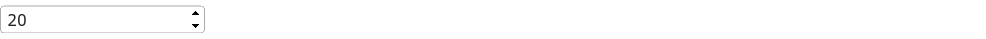

In [15]:
w = SpinnerWidget(value=5)
w

In [16]:
w.value

5

In [17]:
w.value = 20

Trying to use the spinner with another widget.

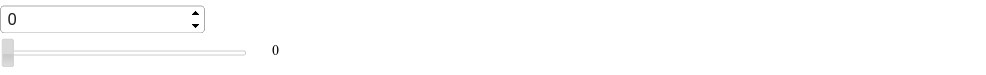

In [18]:
from IPython.display import display
w1 = SpinnerWidget(value=0)
w2 = widgets.IntSlider()
display(w1,w2)

from traitlets import link
mylink = link((w1, 'value'), (w2, 'value'))

[Index](Index.ipynb) - [Back](Widget Styling.ipynb)